In [14]:
%wget https://www.dropbox.com/s/2kpsomtla61gjrn/pretrained.tar
%tar -xvf pretrained.tar

gans  pretrained  pretrained.tar  sampling.ipynb  supervised_deformation_finder


In [3]:
#L
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt

import torchvision
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
from tqdm.auto import tqdm, trange
from PIL import Image

from gans.gan_load import make_stylegan2, make_big_gan


def to_image(tensor, adaptive=False):
    if len(tensor.shape) == 4:
        tensor = tensor[0]
    if adaptive:
        tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    else:
        tensor = ((tensor + 1) / 2).clamp(0, 1)

    return ToPILImage()((255 * tensor.cpu().detach()).to(torch.uint8))


def to_image_grid(tensor, adaptive=False, **kwargs):
    return to_image(make_grid(tensor, **kwargs), adaptive)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# SOTA GANs

Adding attention layer in G at resolution 64


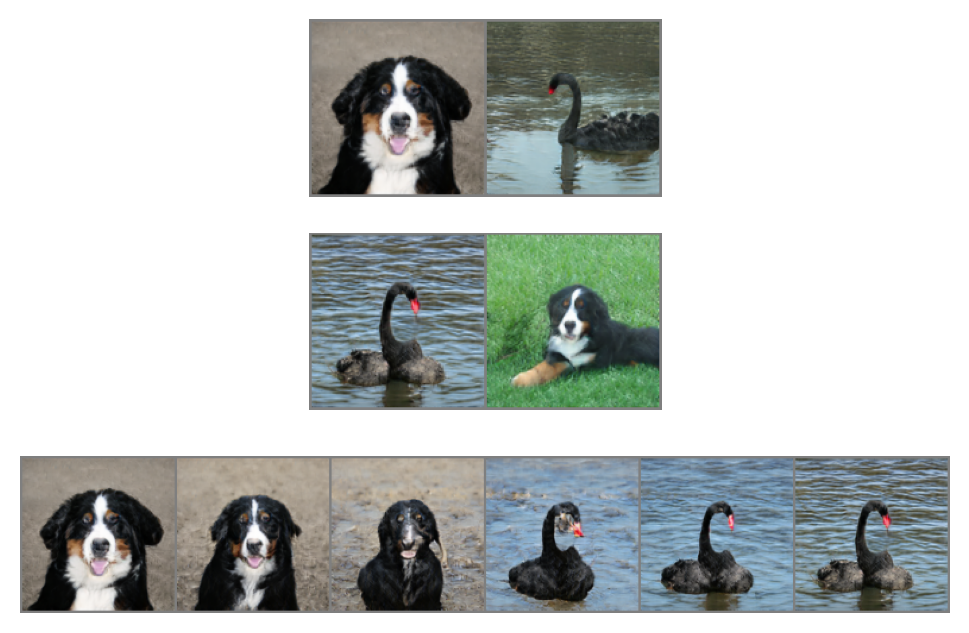

In [4]:
#L
G = make_big_gan('pretrained/G_ema.pth', 128).cuda().eval()

with torch.no_grad():
    z = torch.randn([2, 512]).cuda()
    classes = nn.Parameter(torch.tensor([239, 100], dtype=torch.int64), requires_grad=False).cuda()
    
    cl_embed = G.big_gan.shared(classes)
    cl_embed_swap = torch.stack([cl_embed[1], cl_embed[0]])

    imgs = G.big_gan(z, cl_embed)
    imgs_cl_swap = G.big_gan(z, cl_embed_swap)

    interps = torch.arange(0, 1.01, 0.2).cuda()
    embeds = torch.stack([torch.lerp(cl_embed[0], cl_embed[1], a) for a in interps])

    imgs_cl_interp = G.big_gan(z[0][None].repeat(len(embeds), 1), embeds)
    
_, axs = plt.subplots(3, 1, dpi=200)
for ax in axs: ax.axis('off')

axs[0].imshow(to_image_grid(imgs))
axs[1].imshow(to_image_grid(imgs_cl_swap))
axs[2].imshow(to_image_grid(imgs_cl_interp))

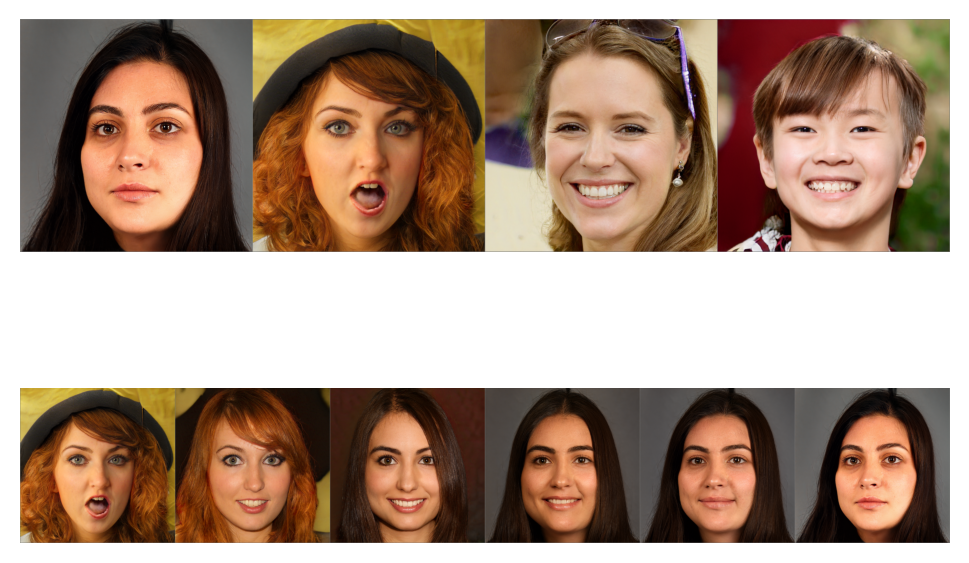

In [6]:
#L
G = make_stylegan2(resolution=1024,
                   weights='pretrained/stylegan2-ffhq-config-f.pt').eval()


with torch.no_grad():
    z = torch.randn([4, 512]).cuda()
    imgs = G(z)

    z = torch.stack([a * z[0] + (1 - a) * z[1] for a in torch.arange(0, 1.01, 0.2)])
    imgs_interp = G(z)

_, axs = plt.subplots(2, 1, dpi=200)
for ax in axs: ax.axis('off')

axs[0].imshow(to_image_grid(imgs, nrow=6))
axs[1].imshow(to_image_grid(imgs_interp, nrow=6))

# Latent Manipulations

In [7]:
#L
from supervised_deformation_finder.model import CelebaAttributeClassifier
from supervised_deformation_finder.utils import \
    prepare_generator_output_for_celeba_regressor as preprocess


print('- Attributes -\n')
with open('supervised_deformation_finder/celeba_attributes.txt') as f:
    attributes = f.readline().split(' ')
    attributes.sort()
    for i, att in enumerate(attributes):
        if i % 4 != 0:
            print(att.ljust(22), end='')
        else:
            print(att)


regressor = CelebaAttributeClassifier('Smiling', 'pretrained/regressor.pth').cuda().eval()

- Attributes -

5_o_Clock_Shadow
Arched_Eyebrows       Attractive            Bags_Under_Eyes       Bald
Bangs                 Big_Lips              Big_Nose              Black_Hair
Blond_Hair            Blurry                Brown_Hair            Bushy_Eyebrows
Chubby                Double_Chin           Eyeglasses            Goatee
Gray_Hair             Heavy_Makeup          High_Cheekbones       Male
Mouth_Slightly_Open   Mustache              Narrow_Eyes           No_Beard
Oval_Face             Pale_Skin             Pointy_Nose           Receding_Hairline
Rosy_Cheeks           Sideburns             Smiling               Straight_Hair
Wavy_Hair             Wearing_Earrings      Wearing_Hat           Wearing_Lipstick
Wearing_Necklace      Wearing_Necktie       Young                 

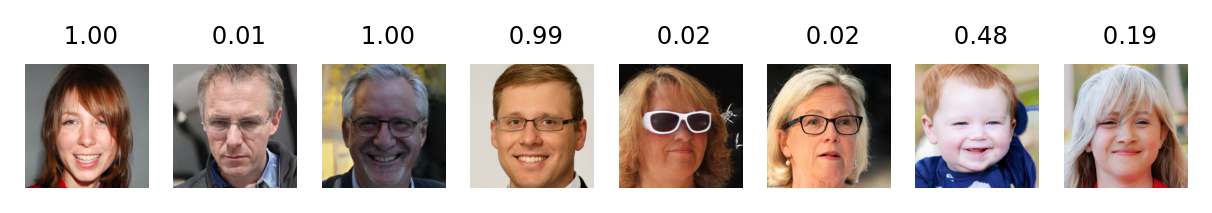

In [8]:
#L
from dataclasses import dataclass
from sklearn.svm import LinearSVR


@dataclass
class ShiftedGSample:
    latent: list = None
    val: float = None


def train_normal(samples, svm_max_iter=10_000):
    num_samples = len(samples)
    latents = torch.stack([s.latent for s in samples])
    expectations = torch.tensor([s.val for s in samples])

    # estimate attribute direction
    print(f'Starting SVM training with {num_samples} samples')
    svm = LinearSVR(max_iter=svm_max_iter)
    svm.fit(latents, expectations)
    normal = torch.from_numpy(svm.coef_).to(torch.float).cuda()

    return normal


# accumulate statistics
num_steps, batch = 200, 8
samples = []
for latents in tqdm(torch.randn([num_steps, batch, 512])):
    with torch.no_grad():
        latents = G.style_gan2.style(latents.cuda())
        imgs = G(latents, w_space=True)
        probs = regressor.get_probs(preprocess(imgs))[:, 1]
    samples += [ShiftedGSample(l, p) for l, p in zip(latents.cpu(), probs.cpu())]

for i, ax in enumerate(plt.subplots(1, len(imgs), dpi=250)[1]):
    ax.axis('off')
    ax.set_title(f'{probs[i].item(): 0.2f}', fontdict=dict(size=7))
    ax.imshow(to_image(imgs[i]))

In [9]:
#L
shift = train_normal(samples, 6000)

Starting SVM training with 1600 samples


/home/avoin/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [ ]:
#L
with torch.no_grad():
    z = torch.randn([8, 512]).cuda()
    imgs_orig = G(z)
    
    w = G.style_gan2.style(z)
    imgs_shifted = G(w - 3 * shift, w_space=True)

to_image_grid(torch.cat([imgs_orig, imgs_shifted]), nrow=len(imgs_orig))